# Run inverse models using MNE

## Simulate data

- Check [this example](https://martinos.org/mne/stable/auto_examples/simulation/plot_simulate_raw_data.html#sphx-glr-auto-examples-simulation-plot-simulate-raw-data-py)
- Or check [this other](https://martinos.org/mne/stable/auto_examples/simulation/plot_simulated_raw_data_using_subject_anatomy.html#sphx-glr-auto-examples-simulation-plot-simulated-raw-data-using-subject-anatomy-py)
- Or yet [another](https://martinos.org/mne/stable/auto_examples/simulation/plot_source_simulator.html#sphx-glr-auto-examples-simulation-plot-source-simulator-py)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import find_events, Epochs, compute_covariance, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (simulate_sparse_stc, simulate_raw, 
                            add_noise, add_ecg, add_eog)

print(__doc__)

Automatically created module for IPython interactive environment


In [8]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)

Opening raw data file /Users/martina.gonzales/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Adding average EEG reference projection.
1 projection items deactivated


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~3.7 MB, data not loaded>

In [9]:
n_dipoles = 4  # number of dipoles to create
epoch_duration = 2.  # duration of each epoch/event
n = 0  # harmonic number
rng = np.random.RandomState(0)  # random state (make reproducible)


def data_fun(times):
    """Generate time-staggered sinusoids at harmonics of 10Hz"""
    global n
    n_samp = len(times)
    window = np.zeros(n_samp)
    start, stop = [int(ii * float(n_samp) / (2 * n_dipoles))
                   for ii in (2 * n, 2 * n + 1)]
    window[start:stop] = 1.
    n += 1
    data = 25e-9 * np.sin(2. * np.pi * 10. * n * times)
    data *= window
    return data

In [10]:
times = raw.times[:int(raw.info['sfreq'] * epoch_duration)]
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
stc = simulate_sparse_stc(src, n_dipoles=n_dipoles, times=times,
                          data_fun=data_fun, random_state=rng)

Reading forward solution from /Users/martina.gonzales/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
Setting up forward solutions
Computing gain matrix for transform #1/1
   Simulating data for forward operator 1/0
   Interval 0.000-2.000 sec
   Interval 2.000-3.999 sec
   Interval 3.999-5.999 sec
   Interval 5.999-7.998 sec
   Interval 7.998-9.998 sec
   Interval 9.998-11.998 sec
   Interval 11.998-13.997 sec
   Interval 13.997-15.997 sec
   Interval 15.997-17.997 sec
   Interval 17.997-19.996 sec
    10 STC iterations provided
Done
Adding noise to 366/376 channels (366 channels in cov)
Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 90.0 mm
Source location file  : dict()
Assuming input in millimeters
Assuming input in MRI coordinates

Positions (in meters) and orientations
1 sources
ecg simulated and trace not stored
Setting up forward solutions
Computing gain matrix for transform #1/1
Sphere                : origin at (0.0 0.0 0.0) mm
    

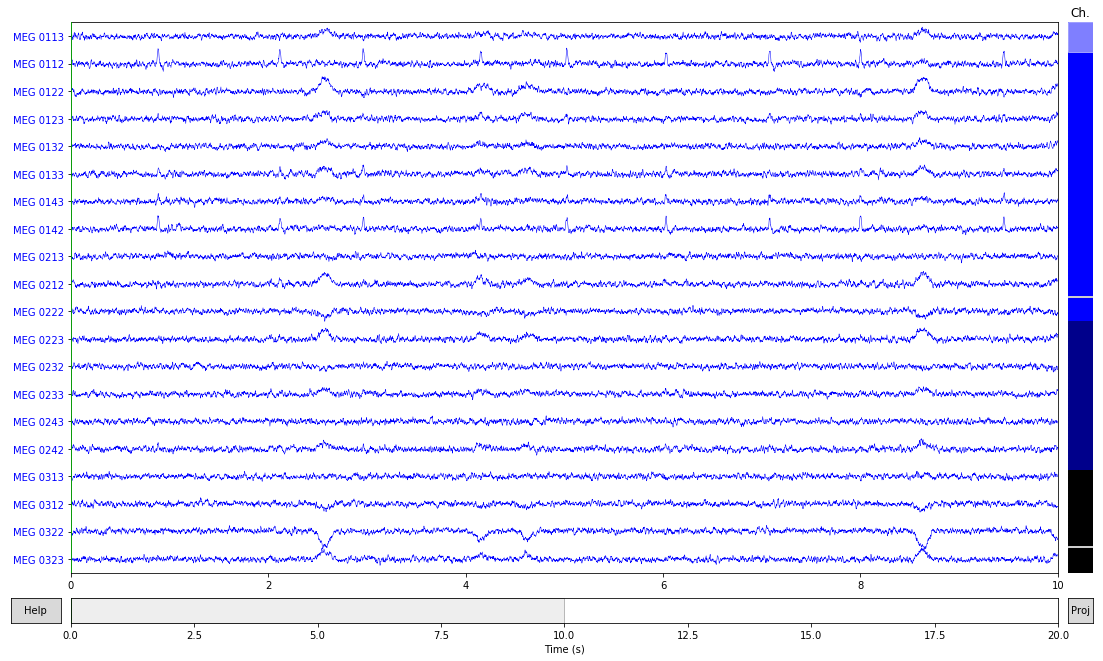

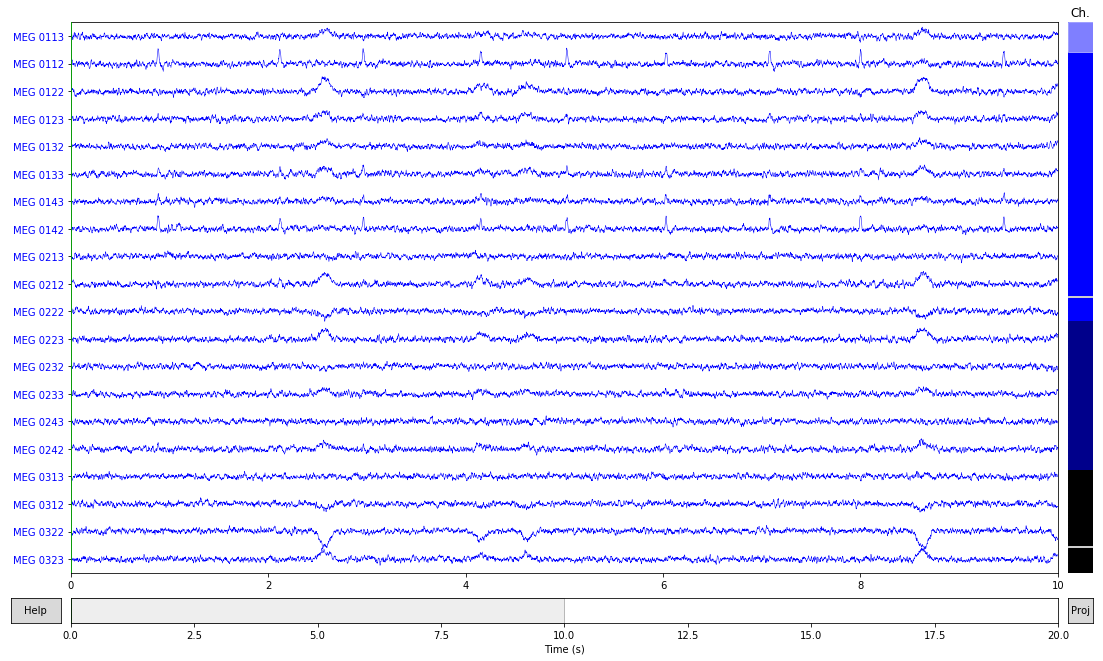

In [11]:
### Simulate raw data
raw_sim = simulate_raw(raw.info, [stc] * 10, forward=fwd, cov=None,
                       verbose=True)
noise_cov = make_ad_hoc_cov(raw_sim.info)
add_noise(raw_sim, noise_cov, iir_filter=[0.2, -0.2, 0.04], random_state=rng)
add_ecg(raw_sim, random_state=rng)
add_eog(raw_sim, random_state=rng)
raw_sim.plot()

## Compute inverse model with MNE

- Details of the [mne make inverse operator](https://martinos.org/mne/stable/generated/mne.minimum_norm.make_inverse_operator.html#mne.minimum_norm.make_inverse_operator)
- Details of the [mne apply inverse operator](https://martinos.org/mne/stable/generated/mne.minimum_norm.apply_inverse_raw.html#mne.minimum_norm.apply_inverse_raw)
- Check [this example](https://martinos.org/mne/stable/auto_examples/inverse/plot_compute_mne_inverse_raw_in_label.html#sphx-glr-auto-examples-inverse-plot-compute-mne-inverse-raw-in-label-py) or [this](https://martinos.org/mne/stable/auto_tutorials/source-modeling/plot_mne_solutions.html#sphx-glr-auto-tutorials-source-modeling-plot-mne-solutions-py) one, or [this](https://martinos.org/mne/stable/auto_examples/inverse/plot_vector_mne_solution.html#sphx-glr-auto-examples-inverse-plot-vector-mne-solution-py) other, and yet [another](https://martinos.org/mne/stable/auto_tutorials/source-modeling/plot_mne_dspm_source_localization.html#tut-inverse-methods)

In [12]:
## Compute inverse operation
inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, noise_cov)

Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020866
    scale = 2.58122e-08 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank=None
    Using tolerance 1.7e-16 (2.2e-16 eps * 305 dim * 0.0025  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 5.2e-18 (2.2e-16 eps * 59 dim * 0.0004  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 project

In [20]:
fwd

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

In [13]:
snr = 1.0  # use smaller SNR for raw data
lambda2 = 1.0 / snr ** 2
method = 'MNE'

stc_mne = mne.minimum_norm.apply_inverse_raw(raw, inv, lambda2, method,
                                             pick_ori=None)


# snr = 3.0
# lambda2 = 1.0 / snr ** 2
# kwargs = dict(initial_time=0.08, hemi='both', subjects_dir=subjects_dir,
#               size=(600, 600))

# stc = abs(apply_inverse(evoked, inv, lambda2, 'MNE', verbose=True))
# brain = stc.plot(figure=1, **kwargs)
# brain.add_text(0.1, 0.9, 'MNE', 'title', font_size=14)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Applying inverse to raw...
    Picked 364 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
[done]


In [ ]:
# data_path = sample.data_path()
# subjects_dir = data_path + '/subjects'

# stc.plot(subjects_dir = subjects_dir)

## Compute inverse model with beamformer

In [15]:
data_cov = mne.compute_raw_covariance(raw)

filters = mne.beamformer.make_lcmv(raw.info, fwd, data_cov, 0.05, noise_cov,
                                   pick_ori='max-power', weight_norm='nai')

Using up to 1388 segments
Number of samples used : 166560
[done]
Computing data rank from covariance with rank='info'
    MEG: rank 302 after 3 projectors applied to 305 channels
    EEG: rank 58 after 1 projector applied to 59 channels
Computing data rank from covariance with rank='info'
    MEG: rank 302 after 3 projectors applied to 305 channels
    EEG: rank 58 after 1 projector applied to 59 channels
Making LCMV beamformer with rank {'meg': 302, 'eeg': 58}
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing data rank from covariance with rank={'meg': 302, 'eeg': 58}
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance ma

In [18]:
stc_bf = mne.beamformer.apply_lcmv_raw(raw, filters, max_ori_out='signed')